In [71]:
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import matplotlib.pyplot as plt
import tarfile
import gzip
import os
from collections import defaultdict
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yannp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
onDrive = False

if onDrive:
    from google.colab import drive
    drive.mount('/content/drive/')


# Exercice 1 Building a neural network to classify texts

Nous allons esseyer de trouvé si une review est positif ou négatif pour cela nous allons utilisé le dataset "IMDB Dataset.csv".

## ======= Charger les données =======
Nous allons tout d'abord importer les données.

In [73]:
if onDrive:
    data = pd.read_csv("/content/drive/MyDrive/AI/Data/IMDB Dataset.csv", sep=",")
else:
    data = pd.read_csv("Data/IMDB Dataset.csv", sep=",")

## ======= première analyse des données =======

nous cherchons d'abord la taille de l'ensemble de données

In [74]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [75]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Nous pouvons ainsi voir tout le texte et ce que nous allons nettoyer (exemple : ```<br /><br />```)

Nous voulons maintenant voir la densité de l'ensemble de données :

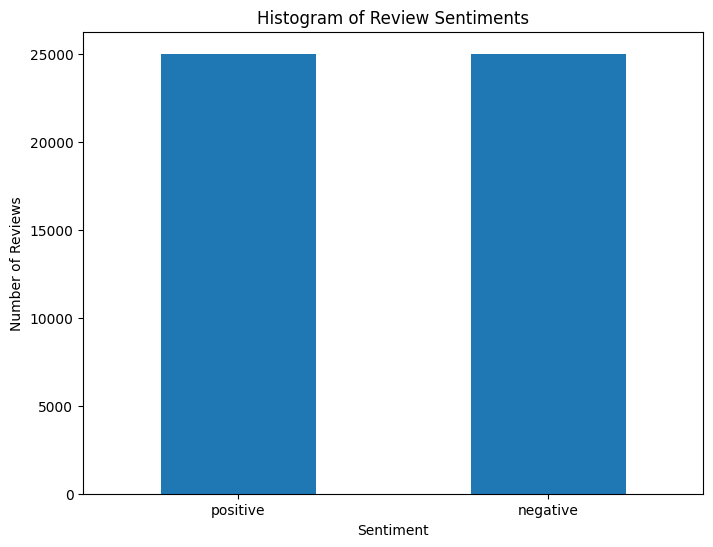

In [76]:
# create graph with number char and +/-
# Counting the number of positive and negative reviews
sentiment_counts = data['sentiment'].value_counts()

# Creating a histogram
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Review Sentiments')
plt.xticks(rotation=0)
plt.show()

Nous voulons maintenant savoir quel est le mot le plus utilisé :

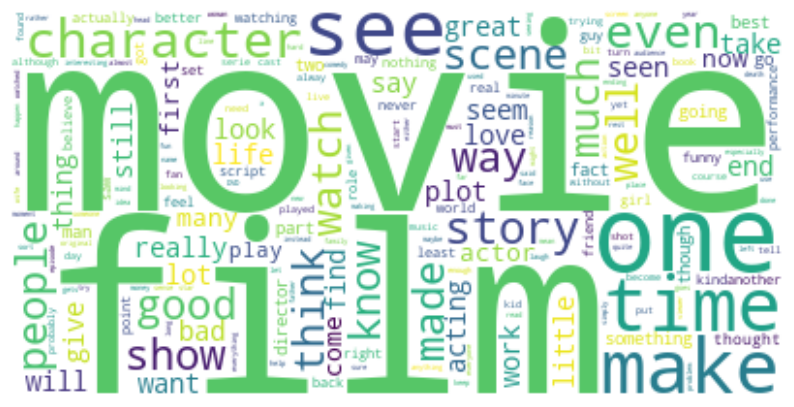

In [77]:
# Importation des librairies nécessaires (si elles ne sont pas déjà importées).
# Par exemple, WordCloud, matplotlib.pyplot, et STOPWORDS.

# Définition d'une fonction pour afficher un nuage de mots.
def display_cloud(data, color):
    # Crée une nouvelle figure matplotlib avec une taille spécifiée.
    plt.subplots(figsize=(10,10))

    # Ajoute un mot spécifique ('br' dans ce cas) à l'ensemble des mots à ignorer.
    STOPWORDS.add('br')

    # Création d'une instance de WordCloud.
    # - Les mots à ignorer sont définis par STOPWORDS.
    # - 'background_color' définit la couleur de fond du nuage de mots.
    # - 'contour_width' et 'contour_color' définissent le contour du nuage.
    # - 'max_words' est le nombre maximum de mots à afficher.
    # - 'max_font_size' est la taille maximale de la police pour les mots.
    # - 'random_state' assure la reproductibilité de la disposition des mots.
    wc = WordCloud(stopwords=STOPWORDS, background_color="white",
                   contour_width=2, contour_color=color,
                   max_words=2000, max_font_size=256, random_state=42)

    # Génère le nuage de mots à partir des données textuelles fournies.
    wc.generate(' '.join(data))

    # Affiche le nuage de mots.
    plt.imshow(wc, interpolation="bilinear")

    # Désactive les axes pour une meilleure visualisation.
    plt.axis('off')

    # Affiche la figure.
    plt.show()

# Appel de la fonction avec un jeu de données 'data['review']' et une couleur de contour 'red'.
display_cloud(data['review'], 'red')


## ======= Netoyage des données =======

Dans cette section nous allons enlever les balise HTML, les nombre et les mots qui ne donne pas de context comme "le" ou "la" par exemple.

De plus nous allons rend la data des sentiments en boolean.

In [78]:
# Importe le module des mots vides en anglais de la bibliothèque NLTK.
english_stops = set(stopwords.words('english'))

# Définition d'une fonction pour charger et pré-traiter le jeu de données.
def load_dataset():
    # Chargement des données à partir d'un fichier CSV.
    if onDrive:
        df = pd.read_csv("/content/drive/MyDrive/AI/Data/IMDB Dataset.csv", sep=",")
    else:
        df = pd.read_csv("Data/IMDB Dataset.csv", sep=",")

    # Sélection des colonnes 'review' et 'sentiment' du DataFrame.
    x_data = df['review']       # Avis (texte)
    y_data = df['sentiment']    # Sentiment (étiquette)

    # PRÉ-TRAITEMENT DES AVIS
    x_data = x_data.replace({'<.*?>': ''}, regex=True)          # Suppression des balises HTML.
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex=True)     # Suppression de tout ce qui n'est pas une lettre.

    # Suppression des mots vides et conversion de chaque avis en liste de mots.
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])

    # Conversion de chaque mot en minuscules.
    x_data = x_data.apply(lambda review: [w.lower() for w in review])

    # ENCODAGE DU SENTIMENT
    # Remplacement de 'positive' par 1 et 'negative' par 0.
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    # Renvoi des données traitées.
    return x_data, y_data

# Chargement des données et réception des ensembles x_data et y_data.
x_data, y_data = load_dataset()

# Division des données en ensembles d'entraînement et de test.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)


C:\Users\yannp\AppData\Local\Temp\ipykernel_12268\2859836284.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_data = y_data.replace('negative', 0)


## ======= Apprentissage =======

Dans ce premier exercise nous allons utilisé un MLP.

Nous créons le model MLP :

In [79]:
# Définition des paramètres pour la tokenisation.
max_words = 10000
max_length = 200

# Création d'un tokenizer Keras avec un nombre maximal de mots et un token pour les mots hors vocabulaire.(https://www.kaggle.com/code/hamishdickson/using-keras-oov-tokens)
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')

# Apprentissage du tokenizer sur les données textuelles.
tokenizer.fit_on_texts(x_data)

# Conversion des textes en séquences de tokens.
sequences = tokenizer.texts_to_sequences(x_data)

# Remplissage (padding) des séquences pour assurer une longueur uniforme.
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='post')

# Division des données tokenisées en ensembles d'entraînement et de test.
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y_data, test_size=0.2)


# Construction du modèle de réseau de neurones multicouches.
model = tf.keras.models.Sequential([
    # Couche d'embedding pour représenter les mots en vecteurs.
    tf.keras.layers.Embedding(max_words, 16, input_length=max_length),
    # Couche de dropout pour réduire le surajustement.
    tf.keras.layers.Dropout(0.5),
    # Aplatir les données pour les couches denses.
    tf.keras.layers.Flatten(),
    # Une autre couche de dropout.
    tf.keras.layers.Dropout(0.5),
    # Couche dense avec activation ReLU.
    tf.keras.layers.Dense(24, activation='relu'),
    # Troisième couche de dropout.
    tf.keras.layers.Dropout(0.5),
    # Couche de sortie avec activation sigmoid pour la classification binaire.
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Compile le modèle avec une fonction de perte et un optimiseur.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 16)           160000    
                                                                 
 dropout_6 (Dropout)         (None, 200, 16)           0         
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dropout_7 (Dropout)         (None, 3200)              0         
                                                                 
 dense_6 (Dense)             (None, 24)                76824     
                                                                 
 dropout_8 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

Nous allons faire un apprentissage avec un early_stopping se qui va permetre d'automatiquement arréter le model:

Epoch 1/50
1250/1250 [==============================] - 5s 3ms/step - loss: 0.5406 - accuracy: 0.6923 - val_loss: 0.3079 - val_accuracy: 0.8745
Epoch 2/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3340 - accuracy: 0.8655 - val_loss: 0.2758 - val_accuracy: 0.8886
Epoch 3/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2842 - accuracy: 0.8862 - val_loss: 0.2662 - val_accuracy: 0.8930
Epoch 4/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2621 - accuracy: 0.8968 - val_loss: 0.2698 - val_accuracy: 0.8896
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2492 - accuracy: 0.9024 - val_loss: 0.2721 - val_accuracy: 0.8931
Epoch 6/50
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2359 - accuracy: 0.9065 - val_loss: 0.2829 - val_accuracy: 0.8833
Epoch 6: early stopping
313/313 [==============================] - 0s 955us/step - loss: 0.2662 - accuracy: 0.8930
Test Accuracy: 89.30%

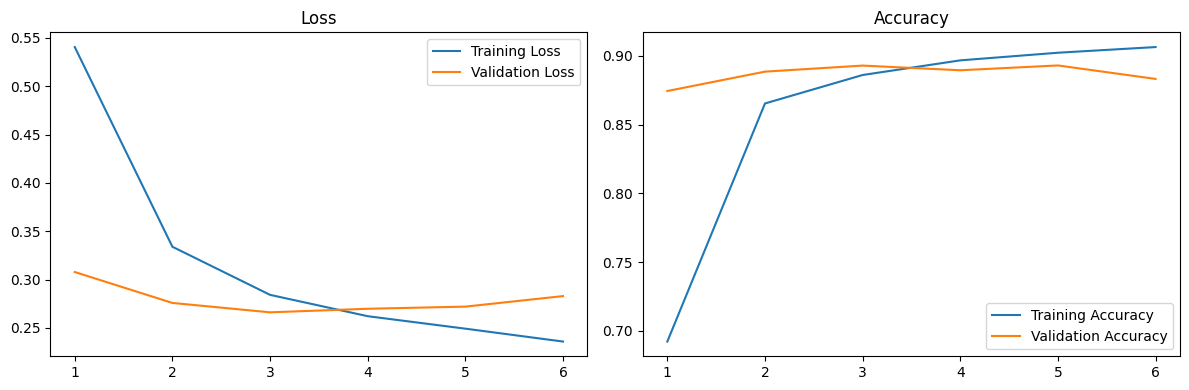

In [80]:
# Configuration de l'arrêt précoce pour éviter le surajustement.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)


# Train the model and store the history
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the Loss and Accuracy
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

on vois que au bout de la 3eme epoque nous avons de l'overfiting.

Notre model a un Test Accuracy de 89.30%

# Exercise 2 : Recurrent Neural Network and IMDB classification

Dans cette exercise nous allons utilisé le meme dataset (donc pas besoin de refaire le pre-traitement) mais cette fois ci avec le model different (LSTM).

In [139]:
# Définition des paramètres pour la tokenisation.
max_words = 10000
max_length = 200

# Création d'un tokenizer Keras avec un nombre maximal de mots et un token pour les mots hors vocabulaire.(https://www.kaggle.com/code/hamishdickson/using-keras-oov-tokens)
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')

# Apprentissage du tokenizer sur les données textuelles.
tokenizer.fit_on_texts(x_data)

# Conversion des textes en séquences de tokens.
sequences = tokenizer.texts_to_sequences(x_data)

# Remplissage (padding) des séquences pour assurer une longueur uniforme.
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating='post', padding='post')

# Division des données tokenisées en ensembles d'entraînement et de test.
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, y_data, test_size=0.2)

# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(max_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Compiler le modèle.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 32)           320000    
                                                                 
 lstm_9 (LSTM)               (None, 64)                24832     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 344897 (1.32 MB)
Trainable params: 344897 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
1250/1250 [==============================] - 50s 39ms/step - loss: 0.6786 - accuracy: 0.5584 - val_loss: 0.6528 - val_accuracy: 0.6432
Epoch 2/50
1250/1250 [==============================] - 48s 39ms/step - loss: 0.6787 - accuracy: 0.5492 - val_loss: 0.6917 - val_accuracy: 0.5136
Epoch 3/50
1250/1250 [==============================] - 48s 39ms/step - loss: 0.6267 - accuracy: 0.6293 - val_loss: 0.6898 - val_accuracy: 0.5088
Epoch 4/50
1250/1250 [==============================] - 48s 39ms/step - loss: 0.6255 - accuracy: 0.6050 - val_loss: 0.4402 - val_accuracy: 0.8181
Epoch 5/50
1250/1250 [==============================] - 49s 39ms/step - loss: 0.2880 - accuracy: 0.8858 - val_loss: 0.3046 - val_accuracy: 0.8727
Epoch 6/50
1250/1250 [==============================] - 50s 40ms/step - loss: 0.1954 - accuracy: 0.9282 - val_loss: 0.3047 - val_accuracy: 0.8747
Epoch 7/50
1250/1250 [==============================] - 48s 39ms/step - loss: 0.1427 - accuracy: 0.9532 - val_loss: 0.3390 -

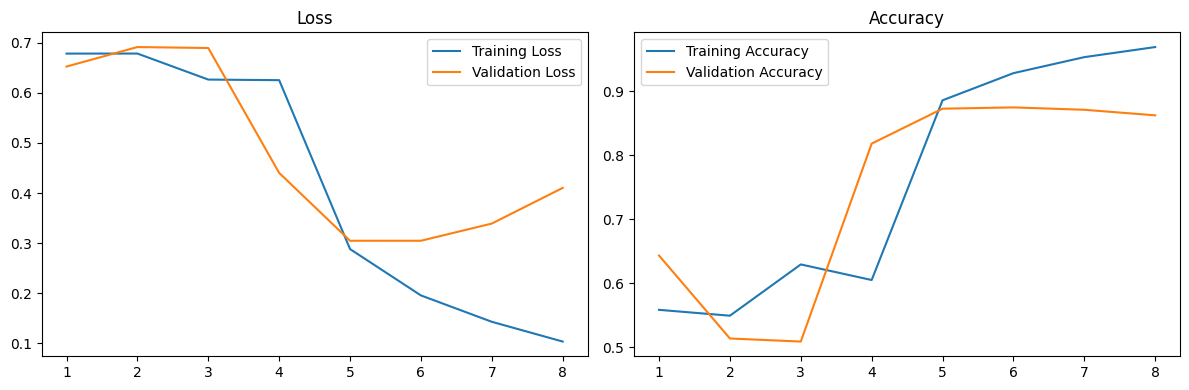

In [140]:
# Configuration de l'arrêt précoce pour éviter le surajustement.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)


# Train the model and store the history
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the Loss and Accuracy
epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Nous pouvont voir que nous avons une val_accuracy equivalente (87.27%).

# Exercise 3 : Text classification on the Ohsumed dataset

Dans cette exercise nous utiliserons le dataset Ohsumed. le dataset se compose d'articles scientifiques de 23 domaine different. nous allons créer une IA qui a partire d'un text article permet de trouvée le le domaine.

## ======= Charger les données =======

Copie des données vers le worspace.

In [83]:
!cp /content/drive/MyDrive/AI/Data/ohsumed\ 20000\ prem.gz /content/

'cp' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [84]:
# Définition d'une fonction pour extraire les fichiers tar.gz.
def extract_tar_gz(filename, extract_path='.'):
    # Ouvrir le fichier gz en mode lecture binaire.
    with gzip.open(filename, 'rb') as f_in:
        # Créer un objet tarfile à partir du contenu décompressé.
        # 'fileobj=f_in' spécifie que la source est le flux décompressé.
        with tarfile.open(fileobj=f_in) as tar:
            # Extraire tous les fichiers dans le dossier spécifié.
            tar.extractall(path=extract_path)

# Appel de la fonction avec le chemin du fichier tar.gz et le dossier de destination.
if onDrive:
    extract_tar_gz('/content/drive/MyDrive/AI/Data/ohsumed 20000 prem.gz', '/content/')
else:
    extract_tar_gz('./Data/ohsumed 20000 prem.gz', './Data')

In [89]:
def get_info(path: str):
    data = list(os.walk(path))[1:]
    files = []
    for d in data:
        folder_name = d[0]
        for file in d[2]:
            if onDrive:
                files.append((folder_name.split('/')[-1], os.path.join(folder_name, file)))
            else:
             files.append((folder_name.split('\\')[-1], os.path.join(folder_name, file)))

    d = defaultdict(int)
    texts = defaultdict(list)
    i = 1
    for (cate, file) in files:
      if i % 500 == 0 :
        print(f"Traitement : {(i*100/len(files)):.1f}% terminé")
      with open(file, 'r') as outfile:
          text = outfile.read()
          texts[cate].append(text)
          words = text_to_word_sequence(text)
          for word in words:
              d[word] += 1
      i+=1
    words = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return (texts, words)


In [90]:
# Appel de la fonction 'get_info' avec le chemin du dossier contenant les documents.
if onDrive:
    texts, words = get_info('/content/ohsumed-first-20000-docs/')
else:
    texts, words = get_info('./Data/ohsumed-first-20000-docs/')
    
# Préparation des données pour créer un DataFrame.
data = []
for category, texts in texts.items():
    for text in texts:
        # Pour chaque texte, ajouter une entrée avec la catégorie et le texte.
        data.append({'Categorie': category, 'Texte': text})

# Création d'un DataFrame à partir de la liste 'data'.
texts_df = pd.DataFrame(data)

Traitement : 2.2% terminé
Traitement : 4.3% terminé
Traitement : 6.5% terminé
Traitement : 8.6% terminé
Traitement : 10.8% terminé
Traitement : 13.0% terminé
Traitement : 15.1% terminé
Traitement : 17.3% terminé
Traitement : 19.4% terminé
Traitement : 21.6% terminé
Traitement : 23.7% terminé
Traitement : 25.9% terminé
Traitement : 28.1% terminé
Traitement : 30.2% terminé
Traitement : 32.4% terminé
Traitement : 34.5% terminé
Traitement : 36.7% terminé
Traitement : 38.9% terminé
Traitement : 41.0% terminé
Traitement : 43.2% terminé
Traitement : 45.3% terminé
Traitement : 47.5% terminé
Traitement : 49.6% terminé
Traitement : 51.8% terminé
Traitement : 54.0% terminé
Traitement : 56.1% terminé
Traitement : 58.3% terminé
Traitement : 60.4% terminé
Traitement : 62.6% terminé
Traitement : 64.8% terminé
Traitement : 66.9% terminé
Traitement : 69.1% terminé
Traitement : 71.2% terminé
Traitement : 73.4% terminé
Traitement : 75.5% terminé
Traitement : 77.7% terminé
Traitement : 79.9% terminé
Trait

## ======= première analyse des données =======

In [91]:
texts_df.head()

,Categorie,Texte
0,C01,Haemophilus influenzae meningitis with prolong...
1,C01,Mucosal intussusception to avoid ascending cho...
2,C01,Gastrointestinal function and structure in HIV...
3,C01,Epidemiology in bone and joint infection.\n Th...
4,C01,The diabetic foot. Soft tissue and bone infect...


On va enlever les C dans la categorie pour avoir que des nombres:

In [92]:
# Suppression du caractère 'C' dans les valeurs de la colonne 'Categorie'.
texts_df['Categorie'] = texts_df['Categorie'].str.replace('C', '')

# Conversion des valeurs de la colonne 'Categorie' en entiers.
texts_df['Categorie'] = texts_df['Categorie'].astype(int)

# Affichage des premières lignes du DataFrame après modification.
texts_df.head()

,Categorie,Texte
0,1,Haemophilus influenzae meningitis with prolong...
1,1,Mucosal intussusception to avoid ascending cho...
2,1,Gastrointestinal function and structure in HIV...
3,1,Epidemiology in bone and joint infection.\n Th...
4,1,The diabetic foot. Soft tissue and bone infect...


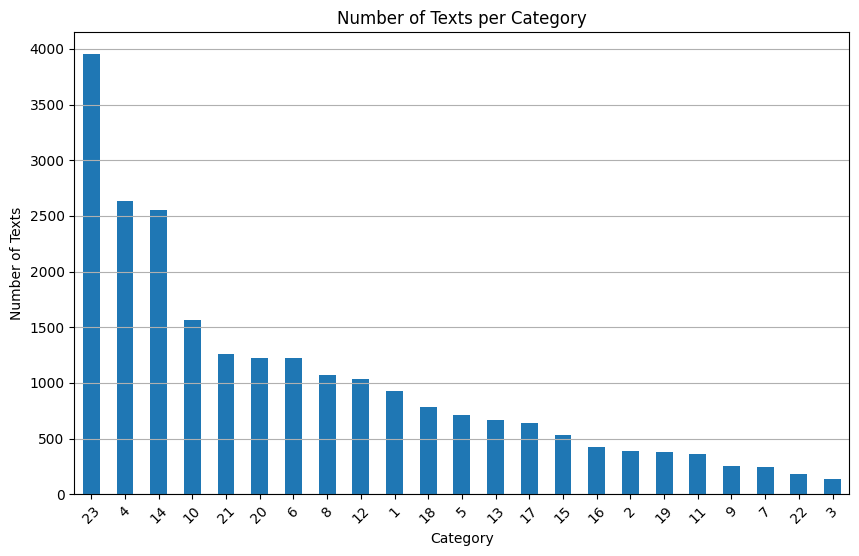

In [93]:
# Comptage du nombre de textes dans chaque catégorie.
category_counts = texts_df['Categorie'].value_counts()

# Préparation du graphique.
plt.figure(figsize=(10, 6))

# Création de l'histogramme.
category_counts.plot(kind='bar')

# Ajout du titre et des étiquettes pour les axes.
plt.title('Number of Texts per Category')
plt.xlabel('Category')
plt.ylabel('Number of Texts')

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité.
plt.xticks(rotation=45)

# Ajout d'une grille sur l'axe des y pour faciliter la lecture des valeurs.
plt.grid(axis='y')

# Affichage du graphique.
plt.show()


Nous pouvons voir que la densité est tres mauvaise. nous alons gardé la densité intacte et nous ferons des modification plus tard.


## ======= Netoyage des données =======

dans cette partie nous allons netoyer les donnée comme pour l'exercise 1 :

In [94]:
# Définition de la fonction pour charger les catégories à partir d'un fichier.
def load_categories(file_path):
    # Initialisation d'un dictionnaire vide pour stocker les catégories.
    categories = {}

    # Ouverture du fichier en mode lecture.
    with open(file_path, 'r') as file:
        # Itération sur chaque ligne du fichier.
        for line in file:
            # Nettoyage de la ligne et division en parties.
            # On suppose que les parties sont séparées par des espaces.
            parts = line.strip().split()

            # Le code de la catégorie est la dernière partie de la ligne.
            category_code = parts[-1]

            # Le nom de la catégorie est constitué de toutes les autres parties.
            category_name = " ".join(parts[:-1])

            # Ajout du nom de la catégorie et de son code dans le dictionnaire.
            categories[category_code] = category_name

    # Renvoi du dictionnaire rempli.
    return categories

# Appel de la fonction pour charger les catégories à partir d'un fichier spécifique.
if onDrive:
    categories = load_categories('/content/drive/MyDrive/AI/Data/ohsumedCategories.txt')
else:
    categories = load_categories('./Data/ohsumedCategories.txt')


# Affichage des catégories chargées.
print(categories)


{'C01': 'Bacterial Infections and Mycoses', 'C02': 'Virus Diseases', 'C03': 'Parasitic Diseases', 'C04': 'Neoplasms', 'C05': 'Musculoskeletal Diseases', 'C06': 'Digestive System Diseases', 'C07': 'Stomatognathic Diseases', 'C08': 'Respiratory Tract Diseases', 'C09': 'Otorhinolaryngologic Diseases', 'C10': 'Nervous System Diseases', 'C11': 'Eye Diseases', 'C12': 'Urologic and Male Genital Diseases', 'C13': 'Female Genital Diseases and Pregnancy Complications', 'C14': 'Cardiovascular Diseases', 'C15': 'Hemic and Lymphatic Diseases', 'C16': 'Neonatal Diseases and Abnormalities', 'C17': 'Skin and Connective Tissue Diseases', 'C18': 'Nutritional and Metabolic Diseases', 'C19': 'Endocrine Diseases', 'C20': 'Immunologic Diseases', 'C21': 'Disorders of Environmental Origin', 'C22': 'Animal Diseases', 'C23': 'Pathological Conditions, Signs and Symptoms'}


Nous voulons un echantillon de N mot les plus utilisé et il faut que ces mot indique du contexte :

In [95]:
# Assurez-vous d'avoir les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Nettoyage du texte
texts_df['Texte'] = texts_df['Texte'].str.lower().str.replace('[^\w\s]', '')

# Tokenisation
texts_df['Tokens'] = texts_df['Texte'].apply(nltk.word_tokenize)

# Suppression des stopwords
stop_words = set(stopwords.words('english'))
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Suppression des nombres
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if not word.isdigit()])

# Jointure des tokens pour reformer le texte
texts_df['Texte'] = texts_df['Tokens'].apply(lambda x: ' '.join(x))

# Stemming
stemmer = PorterStemmer()
texts_df['Stemmed'] = texts_df['Tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Vectorisation (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Vous pouvez ajuster le nombre de features
vectors = tfidf_vectorizer.fit_transform(texts_df['Texte'])

# Convertir les vecteurs TF-IDF en DataFrame pour une utilisation ultérieure
tfidf_df = pd.DataFrame(vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Affichage des premières lignes du DataFrame TF-IDF
tfidf_df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yannp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yannp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,000,0001,001,01,02,05,10,11,12,13,...,woman,women,work,would,wound,year,years,young,younger,yr
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.226075,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.079491,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.079302,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.086344,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.141094,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [96]:
# Calcul des fréquences des mots dans le DataFrame TF-IDF.
word_frequencies = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Sélection des 10 mots les plus fréquents.
top_words = word_frequencies.head(10)

# Affichage des 10 mots les plus fréquents.
top_words


patients     1616.750368
disease       610.187558
treatment     570.022578
patient       500.363848
cases         487.193469
group         483.952141
less          467.080048
cell          447.961868
may           441.919446
two           433.879672
dtype: float64

## ======= Apprentissage MLP =======
Dans un premier temps nous allons utiliser une MLP

In [97]:
# Paramètres pour la tokenisation et le padding
max_vocab_size = 1000  # Nombre maximal de mots dans le vocabulaire
max_sequence_length = 300  # Longueur maximale des séquences

# Préparation des étiquettes
y = texts_df['Categorie'].astype(int)
y_encoded = to_categorical(y)

# Tokenisation et conversion des textes en séquences
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_df['Texte'])
sequences = tokenizer.texts_to_sequences(texts_df['Texte'])

# Padding des séquences
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)
# Création du modèle MLP
model = Sequential()
model.add(Embedding(max_vocab_size, 8, input_length=max_sequence_length))
model.add(Flatten())  # Aplatir les sorties pour les adapter à une couche Dense
model.add(Dense(128, activation='relu'))  # Première couche cachée
model.add(Dropout(0.5))  # Dropout pour la régularisation
model.add(Dense(64, activation='relu'))  # Deuxième couche cachée
model.add(Dropout(0.5))  # Dropout pour la régularisation
model.add(Dense(y_encoded.shape[1], activation='softmax'))  # Couche de sortie

# Compilation du modèle
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 8)            8000      
                                                                 
 flatten_3 (Flatten)         (None, 2400)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               307328    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 24)               

Epoch 1/10
580/580 [==============================] - 2s 3ms/step - loss: 2.8049 - accuracy: 0.1766 - val_loss: 2.6047 - val_accuracy: 0.2406
Epoch 2/10
580/580 [==============================] - 2s 3ms/step - loss: 2.5666 - accuracy: 0.2598 - val_loss: 2.4897 - val_accuracy: 0.2823
Epoch 3/10
580/580 [==============================] - 2s 3ms/step - loss: 2.4549 - accuracy: 0.2840 - val_loss: 2.4553 - val_accuracy: 0.2810
Epoch 4/10
580/580 [==============================] - 2s 3ms/step - loss: 2.3678 - accuracy: 0.2994 - val_loss: 2.4511 - val_accuracy: 0.2760
Epoch 5/10
580/580 [==============================] - 2s 3ms/step - loss: 2.2939 - accuracy: 0.3107 - val_loss: 2.4422 - val_accuracy: 0.2788
Epoch 6/10
580/580 [==============================] - 2s 3ms/step - loss: 2.2152 - accuracy: 0.3204 - val_loss: 2.4551 - val_accuracy: 0.2741
Epoch 7/10
580/580 [==============================] - 2s 3ms/step - loss: 2.1548 - accuracy: 0.3347 - val_loss: 2.4848 - val_accuracy: 0.2691
Epoch 

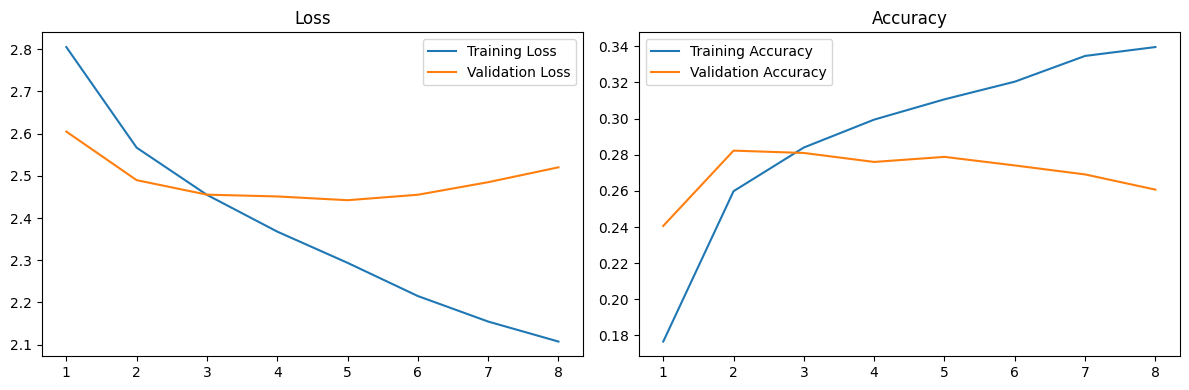

In [98]:
# Division des données en ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Configuration de l'arrêt précoce pour éviter le surajustement.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)


# Entraînement du modèle RNN.
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


# Préparation de la gamme des époques pour le tracé.
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Configuration de la taille et du layout des graphiques.
plt.figure(figsize=(12, 4))

# Tracé de la perte d'entraînement et de validation.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Tracé de la précision d'entraînement et de validation.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Affichage des graphiques.
plt.tight_layout()
plt.show()


On remarque que le model n'arrive pas a trouvé efficassement les classe (val_accuracy = 27.06%) ce qui n'est pas un bon score.

In [99]:
# Évaluation du modèle sur l'ensemble de test pour obtenir la perte et la précision.
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Utilisation du modèle pour faire des prédictions sur l'ensemble de test.
y_pred = model.predict(X_test)

# Conversion des prédictions en classes réelles.
# Note : Ceci est spécifique aux problèmes de classification multi-classes.
y_pred_classes = np.argmax(y_pred, axis=1)

# Conversion des étiquettes de test réelles pour la comparaison.
y_true = np.argmax(y_test, axis=1)


# Importation de la fonction classification_report de scikit-learn.
from sklearn.metrics import classification_report

# Affichage du rapport de classification.
print(classification_report(y_true, y_pred_classes))



145/145 [==============================] - 0s 1ms/step - loss: 2.4422 - accuracy: 0.2788
Loss: 2.4421639442443848, Accuracy: 0.2788088023662567
145/145 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           1       0.07      0.03      0.04       175
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00        28
           4       0.39      0.67      0.49       547
           5       0.00      0.00      0.00       148
           6       0.44      0.02      0.03       233
           7       0.00      0.00      0.00        50
           8       0.00      0.00      0.00       229
           9       0.00      0.00      0.00        50
          10       0.19      0.02      0.03       325
          11       0.00      0.00      0.00        67
          12       0.40      0.03      0.06       179
          13       0.00      0.00      0.00       132
          14       0.44      0.60      0.50 

c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Nous pouvons voire avec details que certaine classe ne sont jamais correctement classifier.

## ======= Apprentissage RNN =======

Faisons un test avec une RNN :

In [100]:
# Définition des paramètres de tokenisation et de padding.
max_vocab_size = 1000  # Taille maximale du vocabulaire
max_sequence_length = 100  # Longueur maximale des séquences

# Conversion des étiquettes en entiers puis en format one-hot.
y = texts_df['Categorie'].astype(int)
y_encoded = to_categorical(y)

# Création et entraînement du tokenizer sur les textes.
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_df['Texte'])

# Conversion des textes en séquences de tokens.
sequences = tokenizer.texts_to_sequences(texts_df['Texte'])

# Padding des séquences pour une longueur uniforme.
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Séparation des données en ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)


# Initialisation du modèle séquentiel.
model = Sequential()

# Ajout d'une couche d'embedding.
# Cette couche transforme les indices des mots en vecteurs denses de taille 8.
# Chaque mot (token) est représenté par un vecteur dans un espace à 8 dimensions.
model.add(Embedding(max_vocab_size, 8, input_length=max_sequence_length))

# Ajout de la première couche LSTM.
# Cette couche a 16 unités (neurones).
# 'return_sequences=True' permet de retourner la séquence complète à la couche suivante.
# 'dropout=0.2' désactive aléatoirement 20% des neurones pour réduire le surajustement.
# 'recurrent_dropout=0.2' désactive aléatoirement 20% des connexions entre les unités de la couche LSTM.
model.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# Ajout de la seconde couche LSTM.
# Cette couche a aussi 16 unités.
# Ici, 'return_sequences' n'est pas défini (False par défaut), donc la couche retourne uniquement la sortie finale.
# 'dropout=0.2' et 'recurrent_dropout=0.5' sont utilisés pour un contrôle accru du surajustement.
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.5))

# Ajout de la couche de sortie.
# La taille de sortie ('y_encoded.shape[1]') correspond au nombre de catégories (classification multi-classes).
# L'activation 'softmax' est utilisée pour calculer une distribution de probabilité sur différentes classes.
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Compilation du modèle.
# 'loss=categorical_crossentropy' est la fonction de perte appropriée pour la classification multi-classes.
# 'optimizer=adam' est un choix courant d'optimiseur, efficace dans diverses applications.
# 'metrics=['accuracy']' indique que la précision sera utilisée pour évaluer les performances du modèle.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Affichage du résumé du modèle pour obtenir un aperçu de sa structure.
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 8)            8000      
                                                                 
 lstm_3 (LSTM)               (None, 100, 16)           1600      
                                                                 
 lstm_4 (LSTM)               (None, 16)                2112      
                                                                 
 dense_12 (Dense)            (None, 24)                408       
                                                                 
Total params: 12120 (47.34 KB)
Trainable params: 12120 (47.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/150
580/580 [==============================] - 44s 69ms/step - loss: 2.8487 - accuracy: 0.1706 - val_loss: 2.8130 - val_accuracy: 0.1675
Epoch 2/150
580/580 [==============================] - 40s 69ms/step - loss: 2.7801 - accuracy: 0.1769 - val_loss: 2.7283 - val_accuracy: 0.1834
Epoch 3/150
580/580 [==============================] - 40s 69ms/step - loss: 2.6874 - accuracy: 0.1979 - val_loss: 2.6779 - val_accuracy: 0.2013
Epoch 4/150
580/580 [==============================] - 40s 68ms/step - loss: 2.6383 - accuracy: 0.2175 - val_loss: 2.6468 - val_accuracy: 0.2141
Epoch 5/150
580/580 [==============================] - 40s 69ms/step - loss: 2.6119 - accuracy: 0.2246 - val_loss: 2.6219 - val_accuracy: 0.2441
Epoch 6/150
580/580 [==============================] - 41s 70ms/step - loss: 2.5749 - accuracy: 0.2457 - val_loss: 2.6062 - val_accuracy: 0.2510
Epoch 7/150
580/580 [==============================] - 40s 69ms/step - loss: 2.5370 - accuracy: 0.2690 - val_loss: 2.5566 - val_ac

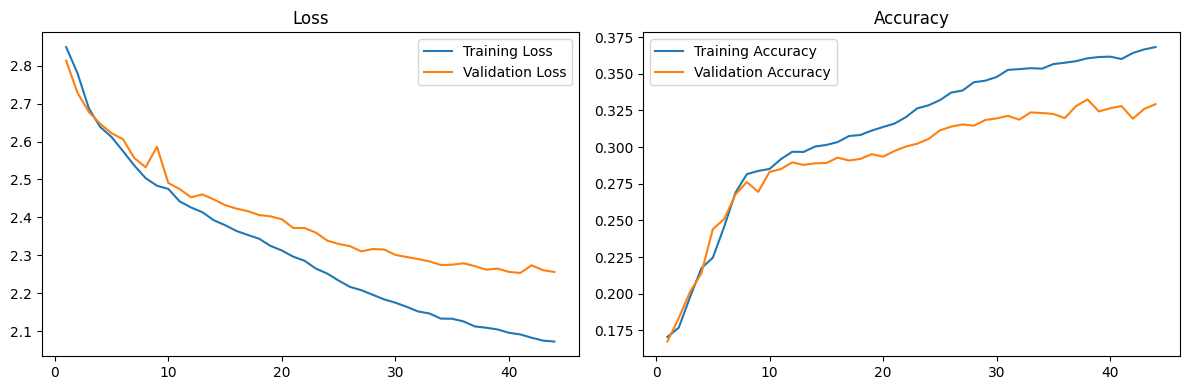

In [101]:
# Séparation des données en ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Configuration du callback EarlyStopping pour éviter le surajustement.
# Il arrêtera l'entraînement si la perte de validation ne s'améliore pas après 3 époques consécutives.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)


# Entraînement du modèle RNN sur les données d'entraînement.
# Le modèle sera validé sur l'ensemble de test à chaque époque.
# L'entraînement s'arrêtera prématurément si nécessaire grâce au callback EarlyStopping.
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Préparation de la gamme des époques pour le tracé.
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Configuration de la taille et du layout des graphiques.
plt.figure(figsize=(12, 4))

# Tracé de la perte d'entraînement et de validation.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Tracé de la précision d'entraînement et de validation.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Affichage des graphiques.
plt.tight_layout()
plt.show()


Ici nous avons un apprentissage assez lent mais c'est le seul moyen pour evité l'overfitting. Nous avons une val_accuracy de 33.37%.

In [102]:
# Évaluation du modèle pour calculer la perte et la précision sur l'ensemble de test.
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Faire des prédictions sur l'ensemble de test.
y_pred = model.predict(X_test)

# Conversion des prédictions en classes réelles.
y_pred_classes = np.argmax(y_pred, axis=1)

# Conversion des étiquettes de test réelles pour la comparaison.
y_true = np.argmax(y_test, axis=1)


# Affichage d'un rapport détaillé sur les performances du modèle.
print(classification_report(y_true, y_pred_classes))

145/145 [==============================] - 2s 11ms/step - loss: 2.2538 - accuracy: 0.3280
Loss: 2.2537736892700195, Accuracy: 0.32801035046577454
145/145 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           1       0.16      0.16      0.16       175
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00        28
           4       0.48      0.67      0.56       547
           5       0.14      0.01      0.02       148
           6       0.33      0.47      0.39       233
           7       0.00      0.00      0.00        50
           8       0.28      0.24      0.26       229
           9       0.00      0.00      0.00        50
          10       0.23      0.21      0.22       325
          11       0.17      0.01      0.03        67
          12       0.21      0.30      0.24       179
          13       0.00      0.00      0.00       132
          14       0.44      0.72      0.

c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [103]:
!rm -rf ./ohsumed-first-20000-docs/ ./ohsumed\ 20000\ prem.gz

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


Comme pour le dernier model nous avons des classes qui se sont jamais classé correctement.

## ======= Apprentissage RNN tout le dataset =======

In [104]:
!cp /content/drive/MyDrive/AI/Data/ohsumed-all-docs.tar.gz /content/

'cp' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [105]:
# Définition d'une fonction pour extraire les fichiers tar.gz.
def extract_tar_gz(filename, extract_path='.'):
    # Ouvrir le fichier gz en mode lecture binaire.
    with gzip.open(filename, 'rb') as f_in:
        # Créer un objet tarfile à partir du contenu décompressé.
        # 'fileobj=f_in' spécifie que la source est le flux décompressé.
        with tarfile.open(fileobj=f_in) as tar:
            # Extraire tous les fichiers dans le dossier spécifié.
            tar.extractall(path=extract_path)

# Appel de la fonction avec le chemin du fichier tar.gz et le dossier de destination.
if onDrive:
    extract_tar_gz('/content/drive/MyDrive/AI/Data/ohsumed-all-docs.tar.gz', '/content/')
else:
    extract_tar_gz('Data/ohsumed-all-docs.tar.gz', './Data')

In [110]:
def get_info(path: str):
    data = list(os.walk(path))[1:]
    files = []
    for d in data:
        folder_name = d[0]
        for file in d[2]:
            files.append((folder_name.split('/')[-1], os.path.join(folder_name, file)))


    d = defaultdict(int)
    texts = defaultdict(list)
    i = 1
    for (cate, file) in files:
      if i % 500 == 0 :
        print(f"Traitement : {(i*100/len(files)):.1f}% terminé")
      with open(file, 'r') as outfile:
          text = outfile.read()
          texts[cate].append(text)
          words = text_to_word_sequence(text)
          for word in words:
              d[word] += 1
      i+=1
    words = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return (texts, words)


In [111]:
# Appel de la fonction 'get_info' avec le chemin du dossier contenant les documents.
if onDrive:
    texts, words = get_info('/content/ohsumed-all/')
else:
    texts, words = get_info('./Data/ohsumed-all/')
    
# Préparation des données pour créer un DataFrame.
data = []
for category, texts in texts.items():
    for text in texts:
        # Pour chaque texte, ajouter une entrée avec la catégorie et le texte.
        data.append({'Categorie': category, 'Texte': text})

# Création d'un DataFrame à partir de la liste 'data'.
texts_df = pd.DataFrame(data)

Traitement : 0.9% terminé
Traitement : 1.8% terminé
Traitement : 2.6% terminé
Traitement : 3.5% terminé
Traitement : 4.4% terminé
Traitement : 5.3% terminé
Traitement : 6.1% terminé
Traitement : 7.0% terminé
Traitement : 7.9% terminé
Traitement : 8.8% terminé
Traitement : 9.7% terminé
Traitement : 10.5% terminé
Traitement : 11.4% terminé
Traitement : 12.3% terminé
Traitement : 13.2% terminé
Traitement : 14.0% terminé
Traitement : 14.9% terminé
Traitement : 15.8% terminé
Traitement : 16.7% terminé
Traitement : 17.5% terminé
Traitement : 18.4% terminé
Traitement : 19.3% terminé
Traitement : 20.2% terminé
Traitement : 21.1% terminé
Traitement : 21.9% terminé
Traitement : 22.8% terminé
Traitement : 23.7% terminé
Traitement : 24.6% terminé
Traitement : 25.4% terminé
Traitement : 26.3% terminé
Traitement : 27.2% terminé
Traitement : 28.1% terminé
Traitement : 29.0% terminé
Traitement : 29.8% terminé
Traitement : 30.7% terminé
Traitement : 31.6% terminé
Traitement : 32.5% terminé
Traitement :

In [112]:
texts_df.head()

,Categorie,Texte
0,C01,Haemophilus influenzae meningitis with prolong...
1,C01,Augmentation mentoplasty using Mersilene mesh....
2,C01,Multiple intracranial mucoceles associated wit...
3,C01,Replacement of an aortic valve cusp after neon...
4,C01,Mucosal intussusception to avoid ascending cho...


In [113]:
# Suppression du caractère 'C' dans les valeurs de la colonne 'Categorie'.
texts_df['Categorie'] = texts_df['Categorie'].str.replace('C', '')

# Conversion des valeurs de la colonne 'Categorie' en entiers.
texts_df['Categorie'] = texts_df['Categorie'].astype(int)

# Affichage des premières lignes du DataFrame après modification.
texts_df.head()

,Categorie,Texte
0,1,Haemophilus influenzae meningitis with prolong...
1,1,Augmentation mentoplasty using Mersilene mesh....
2,1,Multiple intracranial mucoceles associated wit...
3,1,Replacement of an aortic valve cusp after neon...
4,1,Mucosal intussusception to avoid ascending cho...


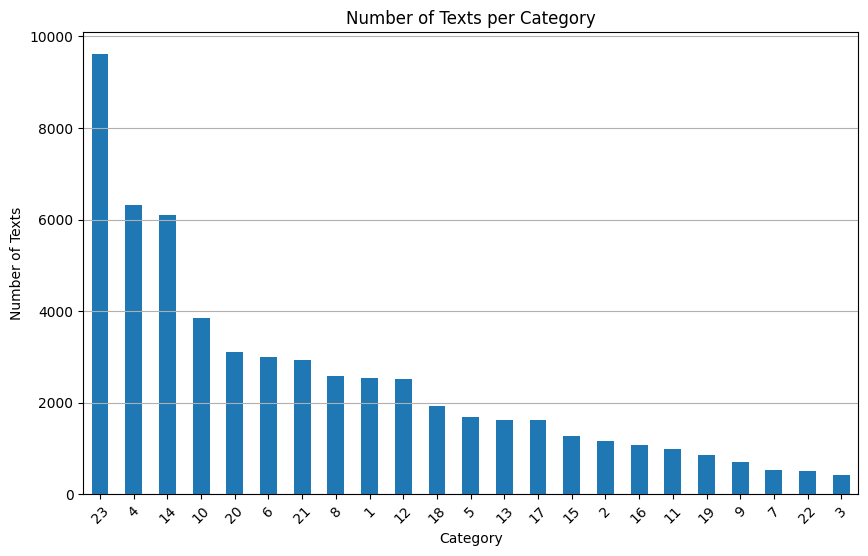

In [114]:
# Comptage du nombre de textes dans chaque catégorie.
category_counts = texts_df['Categorie'].value_counts()

# Préparation du graphique.
plt.figure(figsize=(10, 6))

# Création de l'histogramme.
category_counts.plot(kind='bar')

# Ajout du titre et des étiquettes pour les axes.
plt.title('Number of Texts per Category')
plt.xlabel('Category')
plt.ylabel('Number of Texts')

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité.
plt.xticks(rotation=45)

# Ajout d'une grille sur l'axe des y pour faciliter la lecture des valeurs.
plt.grid(axis='y')

# Affichage du graphique.
plt.show()


In [115]:
# Assurez-vous d'avoir les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Nettoyage du texte
texts_df['Texte'] = texts_df['Texte'].str.lower().str.replace('[^\w\s]', '')

# remove wor with number
texts_df['Texte'] = texts_df['Texte'].str.replace('[0-9]', '')

# Tokenisation
texts_df['Tokens'] = texts_df['Texte'].apply(nltk.word_tokenize)

# Suppression des stopwords
stop_words = set(stopwords.words('english'))
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Suppression des nombres
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if not word.isdigit()])

# Jointure des tokens pour reformer le texte
texts_df['Texte'] = texts_df['Tokens'].apply(lambda x: ' '.join(x))

# Stemming
stemmer = PorterStemmer()
texts_df['Stemmed'] = texts_df['Tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Vectorisation (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Vous pouvez ajuster le nombre de features
vectors = tfidf_vectorizer.fit_transform(texts_df['Texte'])

# Convertir les vecteurs TF-IDF en DataFrame pour une utilisation ultérieure
tfidf_df = pd.DataFrame(vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Affichage des premières lignes du DataFrame TF-IDF
tfidf_df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yannp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yannp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,000,0001,001,01,02,05,10,100,11,12,...,without,woman,women,work,would,wound,year,years,young,yr
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.219775,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.079598,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.321281,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.252127,0.117062,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.099503,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.080373,0.000000,0.0,0.0,0.000000,...,0.067609,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [116]:
# Définition des paramètres de tokenisation et de padding.
max_vocab_size = 1000  # Taille maximale du vocabulaire
max_sequence_length = 100  # Longueur maximale des séquences

# Conversion des étiquettes en entiers puis en format one-hot.
y = texts_df['Categorie'].astype(int)
y_encoded = to_categorical(y)

# Création et entraînement du tokenizer sur les textes.
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_df['Texte'])

# Conversion des textes en séquences de tokens.
sequences = tokenizer.texts_to_sequences(texts_df['Texte'])

# Padding des séquences pour une longueur uniforme.
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Séparation des données en ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)


# Initialisation du modèle séquentiel.
model = Sequential()

# Ajout d'une couche d'embedding.
# Cette couche transforme les indices des mots en vecteurs denses de taille 8.
# Chaque mot (token) est représenté par un vecteur dans un espace à 8 dimensions.
model.add(Embedding(max_vocab_size, 8, input_length=max_sequence_length))

# Ajout de la première couche LSTM.
# Cette couche a 16 unités (neurones).
# 'return_sequences=True' permet de retourner la séquence complète à la couche suivante.
# 'dropout=0.2' désactive aléatoirement 20% des neurones pour réduire le surajustement.
# 'recurrent_dropout=0.2' désactive aléatoirement 20% des connexions entre les unités de la couche LSTM.
model.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# Ajout de la seconde couche LSTM.
# Cette couche a aussi 16 unités.
# Ici, 'return_sequences' n'est pas défini (False par défaut), donc la couche retourne uniquement la sortie finale.
# 'dropout=0.2' et 'recurrent_dropout=0.5' sont utilisés pour un contrôle accru du surajustement.
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.5))

# Ajout de la couche de sortie.
# La taille de sortie ('y_encoded.shape[1]') correspond au nombre de catégories (classification multi-classes).
# L'activation 'softmax' est utilisée pour calculer une distribution de probabilité sur différentes classes.
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Compilation du modèle.
# 'loss=categorical_crossentropy' est la fonction de perte appropriée pour la classification multi-classes.
# 'optimizer=adam' est un choix courant d'optimiseur, efficace dans diverses applications.
# 'metrics=['accuracy']' indique que la précision sera utilisée pour évaluer les performances du modèle.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Affichage du résumé du modèle pour obtenir un aperçu de sa structure.
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 8)            8000      
                                                                 
 lstm_5 (LSTM)               (None, 100, 16)           1600      
                                                                 
 lstm_6 (LSTM)               (None, 16)                2112      
                                                                 
 dense_13 (Dense)            (None, 24)                408       
                                                                 
Total params: 12120 (47.34 KB)
Trainable params: 12120 (47.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/150
1425/1425 [==============================] - 102s 69ms/step - loss: 2.8039 - accuracy: 0.1746 - val_loss: 2.6801 - val_accuracy: 0.2023
Epoch 2/150
1425/1425 [==============================] - 98s 69ms/step - loss: 2.6797 - accuracy: 0.2074 - val_loss: 2.6051 - val_accuracy: 0.2359
Epoch 3/150
1425/1425 [==============================] - 99s 69ms/step - loss: 2.6093 - accuracy: 0.2387 - val_loss: 2.5246 - val_accuracy: 0.2734
Epoch 4/150
1425/1425 [==============================] - 100s 70ms/step - loss: 2.5223 - accuracy: 0.2704 - val_loss: 2.4657 - val_accuracy: 0.2861
Epoch 5/150
1425/1425 [==============================] - 100s 70ms/step - loss: 2.4554 - accuracy: 0.2818 - val_loss: 2.3929 - val_accuracy: 0.2958
Epoch 6/150
1425/1425 [==============================] - 100s 70ms/step - loss: 2.4188 - accuracy: 0.2874 - val_loss: 2.3793 - val_accuracy: 0.3005
Epoch 7/150
1425/1425 [==============================] - 100s 70ms/step - loss: 2.3659 - accuracy: 0.3012 - val_lo

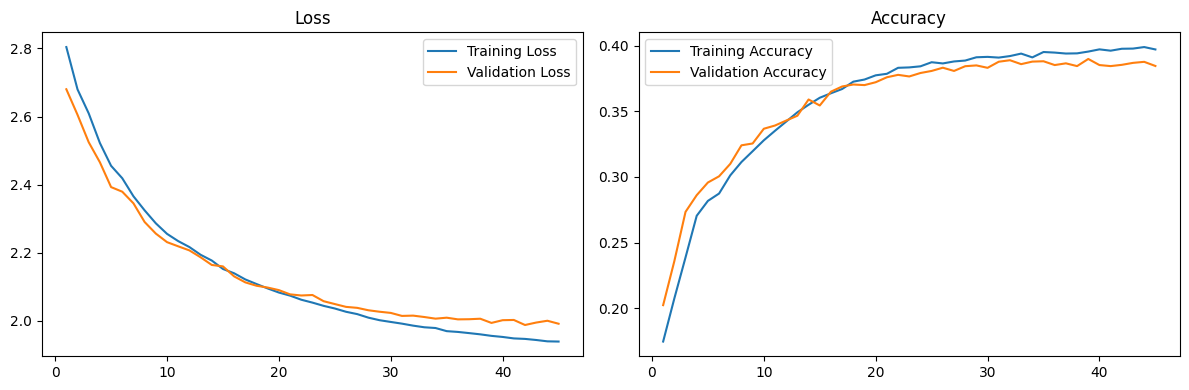

In [117]:
# Séparation des données en ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Configuration du callback EarlyStopping pour éviter le surajustement.
# Il arrêtera l'entraînement si la perte de validation ne s'améliore pas après 3 époques consécutives.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)


# Entraînement du modèle RNN sur les données d'entraînement.
# Le modèle sera validé sur l'ensemble de test à chaque époque.
# L'entraînement s'arrêtera prématurément si nécessaire grâce au callback EarlyStopping.
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Préparation de la gamme des époques pour le tracé.
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Configuration de la taille et du layout des graphiques.
plt.figure(figsize=(12, 4))

# Tracé de la perte d'entraînement et de validation.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Tracé de la précision d'entraînement et de validation.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Affichage des graphiques.
plt.tight_layout()
plt.show()


Le code est encore plus lent mais nous avons une val_accuracy de 38.15%.

In [118]:
# Évaluation du modèle pour calculer la perte et la précision sur l'ensemble de test.
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Faire des prédictions sur l'ensemble de test.
y_pred = model.predict(X_test)

# Conversion des prédictions en classes réelles.
y_pred_classes = np.argmax(y_pred, axis=1)

# Conversion des étiquettes de test réelles pour la comparaison.
y_true = np.argmax(y_test, axis=1)


# Affichage d'un rapport détaillé sur les performances du modèle.
print(classification_report(y_true, y_pred_classes))

357/357 [==============================] - 4s 10ms/step - loss: 1.9880 - accuracy: 0.3855
Loss: 1.988037347793579, Accuracy: 0.3854523003101349
357/357 [==============================] - 4s 10ms/step
              precision    recall  f1-score   support

           1       0.33      0.36      0.34       507
           2       0.20      0.06      0.09       244
           3       0.50      0.01      0.02        89
           4       0.46      0.67      0.54      1279
           5       0.25      0.16      0.20       328
           6       0.41      0.44      0.42       589
           7       0.00      0.00      0.00       103
           8       0.33      0.42      0.37       490
           9       0.20      0.01      0.01       152
          10       0.34      0.34      0.34       760
          11       0.35      0.35      0.35       188
          12       0.37      0.49      0.42       473
          13       0.34      0.43      0.38       317
          14       0.53      0.72      0.61

c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\yannp\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## ======= Apprentissage RNN avec sous/sur-échantillonnage =======

Dans cette partie nous allons etudier l'impact du sous/sur-échantillonnage sur les performance de notre model.
Nous allons essayer que le sur-échantillonnage.

In [131]:
def get_info(path: str):
    data = list(os.walk(path))[1:]
    files = []
    for d in data:
        folder_name = d[0]
        for file in d[2]:
            files.append((folder_name.split('/')[-1], os.path.join(folder_name, file)))

    d = defaultdict(int)
    texts = defaultdict(list)
    i = 1
    for (cate, file) in files:
      if i % 500 == 0 :
        print(f"Traitement : {(i*100/len(files)):.1f}% terminé")
      with open(file, 'r') as outfile:
          text = outfile.read()
          texts[cate].append(text)
          words = text_to_word_sequence(text)
          for word in words:
              d[word] += 1
      i+=1
    words = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return (texts, words)


In [132]:
# Appel de la fonction 'get_info' avec le chemin du dossier contenant les documents.
if onDrive:
    texts, words = get_info('/content/ohsumed-all/')
else:
    texts, words = get_info('./Data/ohsumed-all/')
# Préparation des données pour créer un DataFrame.
data = []
for category, texts in texts.items():
    for text in texts:
        # Pour chaque texte, ajouter une entrée avec la catégorie et le texte.
        data.append({'Categorie': category, 'Texte': text})

# Création d'un DataFrame à partir de la liste 'data'.
texts_df = pd.DataFrame(data)
texts_df

Traitement : 0.9% terminé
Traitement : 1.8% terminé
Traitement : 2.6% terminé
Traitement : 3.5% terminé
Traitement : 4.4% terminé
Traitement : 5.3% terminé
Traitement : 6.1% terminé
Traitement : 7.0% terminé
Traitement : 7.9% terminé
Traitement : 8.8% terminé
Traitement : 9.7% terminé
Traitement : 10.5% terminé
Traitement : 11.4% terminé
Traitement : 12.3% terminé
Traitement : 13.2% terminé
Traitement : 14.0% terminé
Traitement : 14.9% terminé
Traitement : 15.8% terminé
Traitement : 16.7% terminé
Traitement : 17.5% terminé
Traitement : 18.4% terminé
Traitement : 19.3% terminé
Traitement : 20.2% terminé
Traitement : 21.1% terminé
Traitement : 21.9% terminé
Traitement : 22.8% terminé
Traitement : 23.7% terminé
Traitement : 24.6% terminé
Traitement : 25.4% terminé
Traitement : 26.3% terminé
Traitement : 27.2% terminé
Traitement : 28.1% terminé
Traitement : 29.0% terminé
Traitement : 29.8% terminé
Traitement : 30.7% terminé
Traitement : 31.6% terminé
Traitement : 32.5% terminé
Traitement :

,Categorie,Texte
0,C01,Haemophilus influenzae meningitis with prolong...
1,C01,Augmentation mentoplasty using Mersilene mesh....
2,C01,Multiple intracranial mucoceles associated wit...
3,C01,Replacement of an aortic valve cusp after neon...
4,C01,Mucosal intussusception to avoid ascending cho...
...,...,...
56979,C23,Ionized calcium in blood: studies on patients ...
56980,C23,Effects of immediate postoperative enteral nut...
56981,C23,Effects of enteral fat emulsion on fat absorpt...
56982,C23,Inhibition of early atherogenesis in transgeni...


In [133]:
# Suppression du caractère 'C' dans les valeurs de la colonne 'Categorie'.
texts_df['Categorie'] = texts_df['Categorie'].str.replace('C', '')

# Conversion des valeurs de la colonne 'Categorie' en entiers.
texts_df['Categorie'] = texts_df['Categorie'].astype(int)

# Affichage des premières lignes du DataFrame après modification.
texts_df.head()

,Categorie,Texte
0,1,Haemophilus influenzae meningitis with prolong...
1,1,Augmentation mentoplasty using Mersilene mesh....
2,1,Multiple intracranial mucoceles associated wit...
3,1,Replacement of an aortic valve cusp after neon...
4,1,Mucosal intussusception to avoid ascending cho...


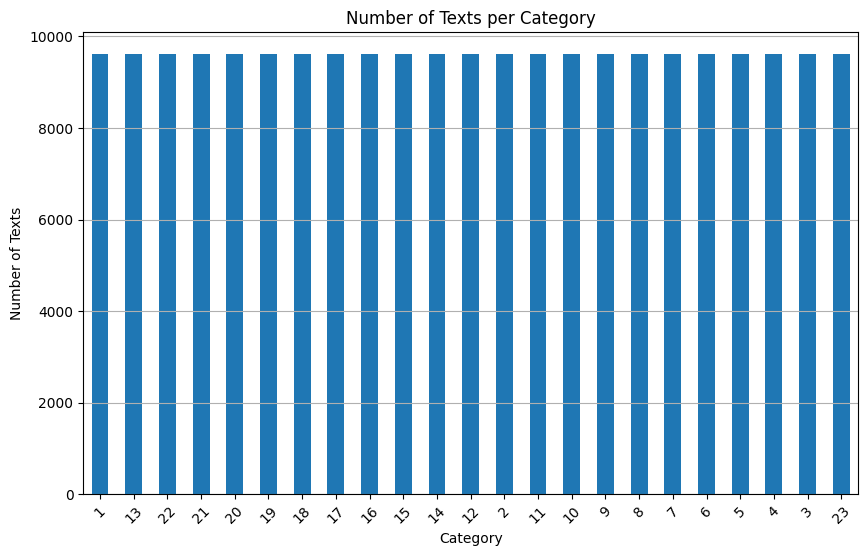

In [134]:
sous = False

def generate_new_text(texts):
    new_text = ' '.join(random.sample(texts.split(), len(texts.split())))
    return new_text

if sous:
    # Obtenir le nombre minimum de textes dans une catégorie
    min_count = category_counts.min()
    # Sous-échantillonner chaque catégorie
    texts_df = texts_df.groupby('Categorie').sample(n=min_count, random_state=1)
else:
    # Obtenir le nombre maximal de textes dans une catégorie
    max_count = category_counts.max()
    # Sur-échantillonner chaque catégorie
    for category in texts_df['Categorie'].unique():
        current_count = texts_df[texts_df['Categorie'] == category].shape[0]
        deficit = max_count - current_count
        new_texts = []
        while deficit > 0:
            # Sélection aléatoire d'un texte de la catégorie
            sample_text = texts_df[texts_df['Categorie'] == category].sample(1).iloc[0]['Texte']
            # Générer un nouveau texte
            new_text = generate_new_text(sample_text)
            new_texts.append({'Categorie': category, 'Texte': new_text})
            deficit -= 1
        # Ajouter les nouveaux textes au DataFrame
        new_texts_df = pd.DataFrame(new_texts)
        texts_df = pd.concat([texts_df, new_texts_df], ignore_index=True)


# Comptage du nombre de textes dans chaque catégorie.
category_counts = texts_df['Categorie'].value_counts()

# Préparation du graphique.
plt.figure(figsize=(10, 6))

# Création de l'histogramme.
category_counts.plot(kind='bar')

# Ajout du titre et des étiquettes pour les axes.
plt.title('Number of Texts per Category')
plt.xlabel('Category')
plt.ylabel('Number of Texts')

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité.
plt.xticks(rotation=45)

# Ajout d'une grille sur l'axe des y pour faciliter la lecture des valeurs.
plt.grid(axis='y')

# Affichage du graphique.
plt.show()


In [135]:
# Assurez-vous d'avoir les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Nettoyage du texte
texts_df['Texte'] = texts_df['Texte'].str.lower().str.replace('[^\w\s]', '')

# remove wor with number
texts_df['Texte'] = texts_df['Texte'].str.replace('[0-9]', '')

# Tokenisation
texts_df['Tokens'] = texts_df['Texte'].apply(nltk.word_tokenize)

# Suppression des stopwords
stop_words = set(stopwords.words('english'))
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Suppression des nombres
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if not word.isdigit()])

# Jointure des tokens pour reformer le texte
texts_df['Texte'] = texts_df['Tokens'].apply(lambda x: ' '.join(x))

# Stemming
stemmer = PorterStemmer()
texts_df['Stemmed'] = texts_df['Tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Vectorisation (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Vous pouvez ajuster le nombre de features
vectors = tfidf_vectorizer.fit_transform(texts_df['Texte'])

# Convertir les vecteurs TF-IDF en DataFrame pour une utilisation ultérieure
tfidf_df = pd.DataFrame(vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Affichage des premières lignes du DataFrame TF-IDF
tfidf_df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yannp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yannp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,000,0001,001,01,02,05,10,100,11,12,...,whose,within,without,woman,women,would,year,years,young,yr
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.211065,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.076970,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.314177,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.250065,0.117164,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.095418,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.081248,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.068577,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [136]:
# Définition des paramètres de tokenisation et de padding.
max_vocab_size = 1000  # Taille maximale du vocabulaire
max_sequence_length = 100  # Longueur maximale des séquences

# Conversion des étiquettes en entiers puis en format one-hot.
y = texts_df['Categorie'].astype(int)
y_encoded = to_categorical(y)

# Création et entraînement du tokenizer sur les textes.
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_df['Texte'])

# Conversion des textes en séquences de tokens.
sequences = tokenizer.texts_to_sequences(texts_df['Texte'])

# Padding des séquences pour une longueur uniforme.
X_padded = pad_sequences(sequences, maxlen=max_sequence_length)

# Séparation des données en ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)


# Initialisation du modèle séquentiel.
model = Sequential()

# Ajout d'une couche d'embedding.
# Cette couche transforme les indices des mots en vecteurs denses de taille 8.
# Chaque mot (token) est représenté par un vecteur dans un espace à 8 dimensions.
model.add(Embedding(max_vocab_size, 8, input_length=max_sequence_length))

# Ajout de la première couche LSTM.
# Cette couche a 16 unités (neurones).
# 'return_sequences=True' permet de retourner la séquence complète à la couche suivante.
# 'dropout=0.2' désactive aléatoirement 20% des neurones pour réduire le surajustement.
# 'recurrent_dropout=0.2' désactive aléatoirement 20% des connexions entre les unités de la couche LSTM.
model.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

# Ajout de la seconde couche LSTM.
# Cette couche a aussi 16 unités.
# Ici, 'return_sequences' n'est pas défini (False par défaut), donc la couche retourne uniquement la sortie finale.
# 'dropout=0.2' et 'recurrent_dropout=0.5' sont utilisés pour un contrôle accru du surajustement.
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.5))

# Ajout de la couche de sortie.
# La taille de sortie ('y_encoded.shape[1]') correspond au nombre de catégories (classification multi-classes).
# L'activation 'softmax' est utilisée pour calculer une distribution de probabilité sur différentes classes.
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Compilation du modèle.
# 'loss=categorical_crossentropy' est la fonction de perte appropriée pour la classification multi-classes.
# 'optimizer=adam' est un choix courant d'optimiseur, efficace dans diverses applications.
# 'metrics=['accuracy']' indique que la précision sera utilisée pour évaluer les performances du modèle.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Affichage du résumé du modèle pour obtenir un aperçu de sa structure.
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 8)            8000      
                                                                 
 lstm_7 (LSTM)               (None, 100, 16)           1600      
                                                                 
 lstm_8 (LSTM)               (None, 16)                2112      
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
Total params: 12120 (47.34 KB)
Trainable params: 12120 (47.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/150
1382/1382 [==============================] - 111s 80ms/step - loss: 2.4419 - accuracy: 0.2739 - val_loss: 2.3815 - val_accuracy: 0.3020
Epoch 2/150
1382/1382 [==============================] - 112s 81ms/step - loss: 2.3646 - accuracy: 0.3071 - val_loss: 2.3080 - val_accuracy: 0.3253
Epoch 3/150
1382/1382 [==============================] - 117s 84ms/step - loss: 2.3092 - accuracy: 0.3286 - val_loss: 2.2558 - val_accuracy: 0.3500
Epoch 4/150
1382/1382 [==============================] - 118s 85ms/step - loss: 2.2564 - accuracy: 0.3469 - val_loss: 2.2042 - val_accuracy: 0.3659
Epoch 5/150
1382/1382 [==============================] - 120s 87ms/step - loss: 2.2072 - accuracy: 0.3628 - val_loss: 2.1523 - val_accuracy: 0.3821
Epoch 6/150
1382/1382 [==============================] - 120s 87ms/step - loss: 2.1644 - accuracy: 0.3758 - val_loss: 2.1189 - val_accuracy: 0.3920
Epoch 7/150
1382/1382 [==============================] - 118s 85ms/step - loss: 2.1301 - accuracy: 0.3853 - val_

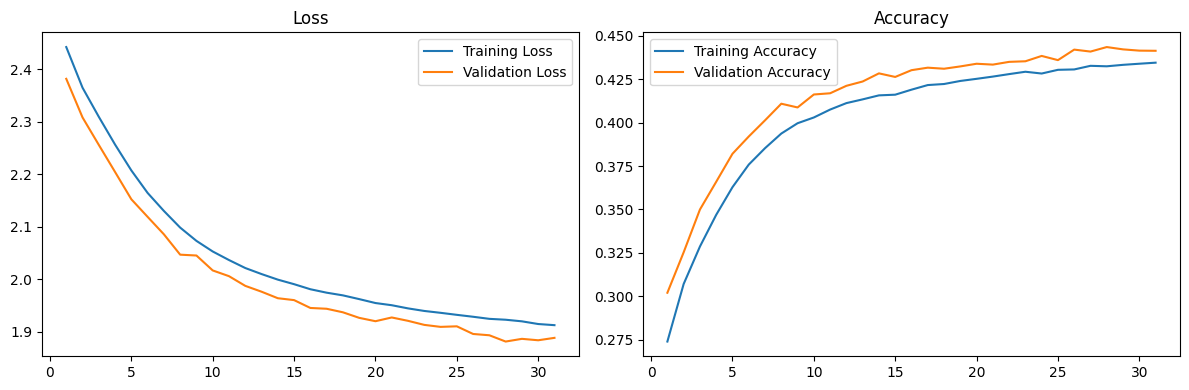

In [138]:
# Séparation des données en ensembles d'entraînement et de test.
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Configuration du callback EarlyStopping pour éviter le surajustement.
# Il arrêtera l'entraînement si la perte de validation ne s'améliore pas après 3 époques consécutives.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)


# Entraînement du modèle RNN sur les données d'entraînement.
# Le modèle sera validé sur l'ensemble de test à chaque époque.
# L'entraînement s'arrêtera prématurément si nécessaire grâce au callback EarlyStopping.
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Préparation de la gamme des époques pour le tracé.
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Configuration de la taille et du layout des graphiques.
plt.figure(figsize=(12, 4))

# Tracé de la perte d'entraînement et de validation.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Tracé de la précision d'entraînement et de validation.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Affichage des graphiques.
plt.tight_layout()
plt.show()


On remarque que le model a augmenté en performance avec un val_accuracy de 44.14%.